### Three-Layer NTK

[NTK paper](https://papers.nips.cc/paper/2019/file/c4ef9c39b300931b69a36fb3dbb8d60e-Paper.pdf)

[GitHub Repo for this project](https://github.com/genglinliu/NTK-study)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

#### Activation Functions, Plot Functions, Input Initialization, Utility Functions to Check Matrix

In [2]:
"""
activation functions and their derivatives
"""

def relu_k(x, k):
    return np.maximum(x**k, 0)

def d_relu_k(x, k):
    return k * x**(k-1) * (x > 0)

def relu(x):
    return np.maximum(x, 0)

def d_relu(x):
    return 1.0 * (x > 0)

def sin(x, k=None):
    return np.sin(x)

def cos(x, k=None):
    return np.cos(x)

def d_cos(x, k=None):
    return -np.sin(x)

In [3]:
def init_inputs(num_inputs=400):
    # sin(theta) and cos(theta), theta ~ (0, 2*pi) uniformly sampled
    # take 100 points on the unit circle
    theta = np.linspace(0.0, 2 * np.pi, num=num_inputs)
    x = np.asarray((np.cos(theta), np.sin(theta))) # (2, 100)
    return x

In [4]:
def plot_eigendecay(kernel, label):
    # plot
    eigenvalues = np.linalg.eigvals(kernel)
    # sort in descending order
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    plt.loglog(sorted_eigenvalues[:-1], label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_eigendecay_trig(kernel, label):
    # plot
    eigenvalues = np.linalg.eigvals(kernel)
    # sort in descending order
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    plt.yscale('log')
    plt.plot(sorted_eigenvalues[:-100], label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
# check kernel symmetry and positive definitiveness
def check(matrix, tol=1e-4):
    error = np.max(matrix - matrix.T) / np.max(matrix)
    if not error < tol:
        print("warning: kernel is not symmetric")
    if not np.all(np.linalg.eigvals(matrix) >= -tol):
        print("warning: kernel is not positive semi-definite")

#### Calculate the NTK - Build the Matrices one by one

In [6]:
"""
see page 3-4 of the paper

ROAD MAP:

STEP 0
    x and x' are 2-dimensional points of shape (2,)
    K_0(x, x') = sigma_0(x, x') = <x, x'> = (x^T).dot(x')

STEP 1a
    B_1 = [sigma_0(x, x),  sigma_0(x, x'),
           sigma_0(x, x'), sigma_0(x', x')]
           
STEP 1b
    sigma_1(x, x') = 2 E(u, v)~N(0, B_1) [activation(u) activation(v)]
    sigma_1'(x, x') = 2 E(u, v)~N(0, B_1) [activation'(u) activation'(v)]

STEP 1c
    K_1(x, x') = sigma_1(x, x') + K_0(x, x') sigma_1'(x, x')
    
    
STEP 2a
    B_2 = [sigma_1(x, x),  sigma_1(x, x'),
           sigma_1(x, x'), sigma_1(x', x')]
           
STEP 2b
    sigma_2(x, x') = 2 E(u, v)~N(0, B_2) [activation(u) activation(v)]
    sigma_2'(x, x') = 2 E(u, v)~N(0, B_2) [activation'(u) activation'(v)]

STEP 2c
    K_2(x, x') = sigma_2(x, x') + K_1(x, x') sigma_2'(x, x')

"""
pass

In [7]:
#--------------------
# step 0: K0, sigma_0
#--------------------

# init input
X = init_inputs(num_inputs=400) # (2, num_inputs)
num_inputs = X.shape[1]

# activation function setup
activation_map = {
    'relu_k': [relu_k, d_relu_k],
    'sin': [sin, cos],
    'cos': [cos, d_cos]
}

def calc_K0():
    return np.dot(X.T, X)  # (num_inputs, num_inputs)

def calc_sigma0():
    return np.dot(X.T, X)  # (num_inputs, num_inputs)

In [8]:
#--------------------
# step 1a: build B_1
#--------------------
def calc_B1():
    # because x == x', all the sigma_0's are the same
    # B_1 is a concatenation of 4 of them
    sigma_0 = calc_sigma0()
    v1 = np.vstack((sigma_0, sigma_0))
    v2 = np.vstack((sigma_0, sigma_0))
    B_1 = np.hstack((v1, v2)) #(2*num_inputs, 2*num_inputs)
    
    return B_1

In [9]:
#--------------------
# step 1b: sigma_1
#--------------------

def calc_sigma_1(activation_h1, h1_k):
    
    activation_func, d_activation = activation_map[activation_h1]
    num_samples = 4000
    mean = np.zeros(2 * num_inputs)
    cov = calc_B1()

    # generate 1000 pairs of (u, v), 1st half of the sample is u, 2nd half is v
    sample = np.random.multivariate_normal(mean, cov, num_samples)
    u, v = sample[:, :num_inputs], sample[:, num_inputs:] # (num_samples, num_inputs) = (1000, 100)

    # dot product to sum up the sampled u and v after being activated; this step same as the two-layer case
    expectation_1 = np.dot(activation_func(u, h1_k).T, activation_func(v, h1_k)) / num_samples
    expectation_2 = np.dot(d_activation(u, h1_k).T, d_activation(v, h1_k)) / num_samples

    sigma_1 = 2 * expectation_1
    sigma_1_prime = 2 * expectation_2
    
    return sigma_1, sigma_1_prime

In [10]:
#--------------------
# step 1c: K1
#--------------------
def calc_K1(activation_h1, h1_k):
    K_0 = calc_K0()
    sigma_1, sigma_1_prime = calc_sigma_1(activation_h1, h1_k)
    
    K1 = sigma_1 + K_0 * sigma_1_prime
    check(K1)
    
    return K1

In [11]:
#--------------------
# 2a: B2
#--------------------
def calc_B2(activation_h1, h1_k):
    sigma_1, _ = calc_sigma_1(activation_h1, h1_k)
    v3 = np.vstack((sigma_1, sigma_1))
    v4 = np.vstack((sigma_1, sigma_1))
    B_2 = np.hstack((v3, v4))
    
    return B_2

In [12]:
#--------------------
# 2b: sigma_2
#--------------------

def calc_sigma_2(activation_h1, activation_h2, h1_k, h2_k):
    
    activation_func, d_activation = activation_map[activation_h2]
    num_samples = 4000
    mean = np.zeros(2 * num_inputs)
    cov = calc_B2(activation_h1, h1_k)

    # generate 1000 pairs of (u, v), 1st half of the sample is u, 2nd half is v
    sample = np.random.multivariate_normal(mean, cov, num_samples)
    u, v = sample[:, :num_inputs], sample[:, num_inputs:] # (num_samples, num_inputs) = (1000, 100)

    # dot product to sum up the sampled u and v after being activated; this step same as the two-layer case
    expectation_1 = np.dot(activation_func(u, h2_k).T, activation_func(v, h2_k)) / num_samples
    expectation_2 = np.dot(d_activation(u, h2_k).T, d_activation(v, h2_k)) / num_samples

    sigma_2 = 2 * expectation_1
    sigma_2_prime = 2 * expectation_2
    
    return sigma_2, sigma_2_prime

In [13]:
#--------------------
# step 2c: K2
#--------------------
def calc_K2(activation_h1, activation_h2, h1_k=1, h2_k=1):
    """
    activation_h1 is activation for the 1st hidden layer
    activation_h2 is activation for the 2nd hidden layer
    """
    K_1 = calc_K1(activation_h1, h1_k)
    sigma_2, sigma_2_prime = calc_sigma_2(activation_h1, activation_h2, h1_k, h2_k)
    
    K2 = sigma_2 + K_1 * sigma_2_prime
    check(K2)
    
    return K2

In [14]:
"""
Analytic Solution
page 4 equation (6)-(7)
"""
def kappa_0(u):
    pi = np.pi
    k_0 = (1/pi) * (pi - np.arccos(u))
    return k_0

def kappa_1(u):
    pi = np.pi
    k_1 = (1/pi) * (u * (pi - np.arccos(u)) + np.sqrt(1 - u**2))
    return k_1

def K_0_analytical(x, y):
    return np.dot(x.T, y)

def sigma_0_analytical(x, y):
    return np.dot(x.T, y)

def sigma_1_and_prime_analytical(x, y):
    sig_0_xx = sigma_0_analytical(x, x)
    sig_0_yy = sigma_0_analytical(y, y)
    sig_0_xy = sigma_0_analytical(x, y)
    sqrt_term = np.sqrt(sig_0_xx * sig_0_yy)
    
    u = sig_0_xy / sqrt_term
    k_1 = kappa_1(u)
    sigma_1 = sqrt_term * k_1
    sigma_1_prime = kappa_0(u)
    
    return sigma_1, sigma_1_prime
    
def sigma_2_prime_analytical(x, y):
    sig_1_xx, _ = sigma_1_and_prime_analytical(x, y)
    sig_1_xy, _ = sigma_1_and_prime_analytical(x, y)
    sig_1_yy, _ = sigma_1_and_prime_analytical(y, y)
    sqrt_term = np.sqrt(sig_1_xx * sig_1_yy)
    
    u = sig_1_xy / sqrt_term
    k_1 = kappa_1(u)
    sigma_2 = sqrt_term * k_1
    sigma_2_prime = kappa_0(u)
    
    return sigma_2, sigma_2_prime

def K_1_analytical(x, y):
    sigma_1, sigma_1_prime = sigma_1_and_prime_analytical(x, y)
    K_0 = K_0_analytical(x, y)
    K_1 = sigma_1 + K_0 * sigma_1_prime
    return K_1

def K_2_analytical(x, y):
    sigma_2, sigma_2_prime = sigma_2_prime_analytical(x, y)
    K_1 = K_1_analytical(x, y)
    K_2 = sigma_2 + K_1 * sigma_2_prime
    return K_2

def calc_NTK_analytical():
    # init input
    x = init_inputs() # (2, 100)
    num_inputs = x.shape[1]
    
    # initialize kernel 
    kernel = np.zeros((num_inputs, num_inputs))
    
    for i in range(num_inputs):
        for j in range(num_inputs):
            kernel[i][j] = K_2_analytical(x[:, i], x[:, j])
    
    check(kernel)
    
    return kernel

#### Utility functions to calculate rate/slope of decay under log-log scales

In [15]:
"""
the naive approach takes two end points and calculate the slope:
    calculate slope:
    (x1, y1) => (x2, y2)
    where x1 = 20, x2 = 100 
    y values are eigenvalues[20], eigenvalues[100]
the regression approach fits a linear regression with all the eigenvalues in [20:100]

log(y) = k * log(x) + log(b)

returns k
"""
def calc_slope_naive(kernel):
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    x1 = 20
    x2 = 100
    y1 = np.log2(sorted_eigenvalues[20])
    y2 = np.log2(sorted_eigenvalues[100])
    
    slope = (y2-y1) / (x2-x1)
    b = y1 - slope * x1
    
    return slope

def calc_slope_regression(kernel):
    """ the range between two end points may be adjusted"""
    eigenvalues = np.linalg.eigvals(kernel)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    x = np.log10(np.arange(30, 100))
    y = np.log10(sorted_eigenvalues[30:100])
    
    slope, b = np.polyfit(x, y, deg=1)
    
    return slope

In [16]:
"""
experiment:
1. first hidden layer: smooth (sin/cos), second: non-smooth (ReLU^k)
2. reverse the order of activation
""" 
activation_1 = 'relu_k'
activation_2 = 'sin'
activation_3 = 'cos'

kernel_analytical = calc_NTK_analytical()
K2_relu_relu = calc_K2(activation_1, activation_1)
K2_relu_sin = calc_K2(activation_1, activation_2)
K2_sin_relu = calc_K2(activation_2, activation_1)
K2_sin_sin = calc_K2(activation_2, activation_2)

K2_relu_cos = calc_K2(activation_1, activation_3)

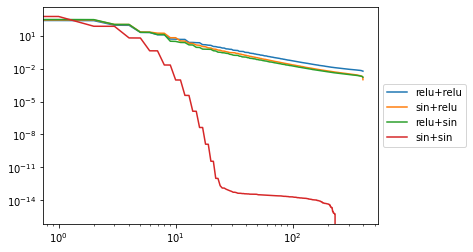

In [17]:
# plot_eigendecay(kernel_analytical, 'analytical')
plot_eigendecay(K2_relu_relu, 'relu+relu')
plot_eigendecay(K2_sin_relu, 'sin+relu')
plot_eigendecay(K2_relu_sin, 'relu+sin')
plot_eigendecay(K2_sin_sin, 'sin+sin')


In [18]:
"""
experiment 3. relu^k decay rate vs (relu^k + sin) decay rate

make table of slopes

         (relu_k)+(relu_k)      (relu_k)+(sin)
K=1          
K=2
K=3
k=4

"""

activation_relu = 'relu_k'
activation_sin = 'sin'

relu_k1 = calc_K2(activation_relu, activation_relu, h1_k=1, h2_k=1)
relu_k2 = calc_K2(activation_relu, activation_relu, h1_k=2, h2_k=2)
relu_k3 = calc_K2(activation_relu, activation_relu, h1_k=3, h2_k=3)
relu_k4 = calc_K2(activation_relu, activation_relu, h1_k=4, h2_k=4)

sin_relu_k1 = calc_K2(activation_sin, activation_relu, h1_k=1)
sin_relu_k2 = calc_K2(activation_sin, activation_relu, h1_k=2)
sin_relu_k3 = calc_K2(activation_sin, activation_relu, h1_k=3)
sin_relu_k4 = calc_K2(activation_sin, activation_relu, h1_k=4)

relu_sin_k1 = calc_K2(activation_relu, activation_sin, h1_k=1)
relu_sin_k2 = calc_K2(activation_relu, activation_sin, h1_k=2)
relu_sin_k3 = calc_K2(activation_relu, activation_sin, h1_k=3)
relu_sin_k4 = calc_K2(activation_relu, activation_sin, h1_k=4)

In [19]:
matrix = sin_relu_k1
np.all(np.linalg.eigvals(matrix) >= -1e-4)

True

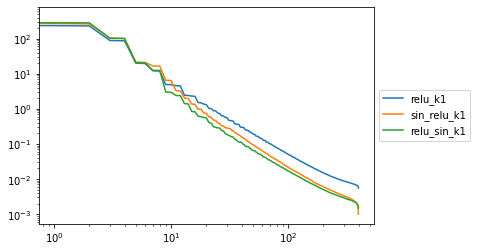

In [20]:
plot_eigendecay( relu_k1, 'relu_k1' )
plot_eigendecay( sin_relu_k1, 'sin_relu_k1' )
plot_eigendecay( relu_sin_k1, 'relu_sin_k1' )

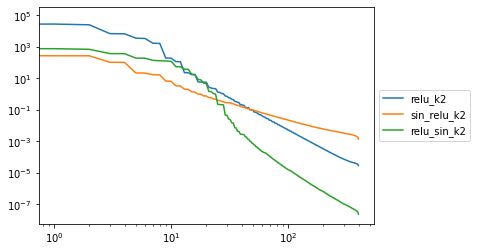

In [21]:
plot_eigendecay( relu_k2, 'relu_k2' )
plot_eigendecay( sin_relu_k2, 'sin_relu_k2' )
plot_eigendecay( relu_sin_k2, 'relu_sin_k2' )

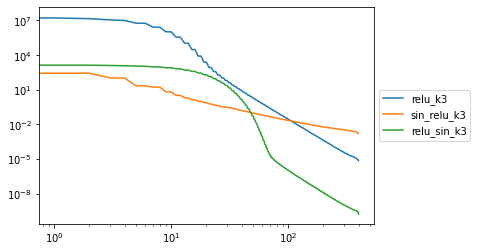

In [22]:
plot_eigendecay( relu_k3, 'relu_k3' )
plot_eigendecay( sin_relu_k3, 'sin_relu_k3' )
plot_eigendecay( relu_sin_k3, 'relu_sin_k3' )

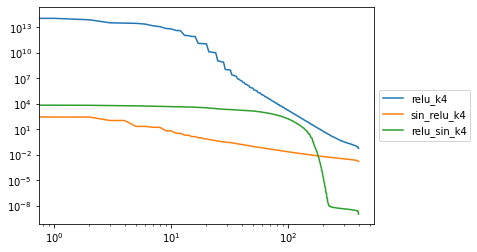

In [23]:
plot_eigendecay( relu_k4, 'relu_k4' )
plot_eigendecay( sin_relu_k4, 'sin_relu_k4' )
plot_eigendecay( relu_sin_k4, 'relu_sin_k4' )

In [24]:
# frequency is the x axis
# smaller eigenvalue -> high frequency
# large eigenvalue -> low frequency
# green curves (relu + sin) cannot learn a lot of high frequency because eigenvalues cluster at above 1. High frequency region is near 0
# blue curves (relu_k) can learn high/mid/low frequency
# fast decay - cannot learn high frequency components as well (check fact) 
# orange curves (sin+relu) have slower decay rate than blue curves
# if we have a function with high/mid/low frequency and use relu+sin activation, then error should be large